# Common pathways across databases

This notebook elucidates the shared pathways (equivalent) between KEGG, Reactome, and WikiPathways.

In [1]:
import os
import numpy as np
import pandas as pd
from bio2bel_kegg.manager import Manager as KeggManager
from bio2bel_wikipathways.manager import Manager as WikiPathwaysManager
from bio2bel_reactome.manager import Manager as ReactomeManager

from collections import Counter
import matplotlib.pyplot as plt

from matplotlib_venn import venn3

In [2]:
%matplotlib inline

Load Established Mappings

In [3]:
kegg_wikipathways_df = pd.read_excel(
    'https://github.com/ComPath/curation/raw/master/mappings/kegg_wikipathways.xlsx',
    index_col=0
)
kegg_reactome_df = pd.read_excel(
    'https://github.com/ComPath/curation/raw/master/mappings/kegg_reactome.xlsx',
    index_col=0
)
wikipathways_reactome_df = pd.read_excel(
    'https://github.com/ComPath/curation/raw/master/mappings/wikipathways_reactome.xlsx',
    index_col=0
)

Call the Database Managers to query gene sets

In [4]:
kegg_manager = KeggManager()
wikipathways_manager = WikiPathwaysManager()
reactome_manager = ReactomeManager()

Methods to extract and process mappings

In [5]:
def get_pathway_ids(manager, names):
    """Return the set of pathway ids given their names and the manager.
    
    :param manager: manager database
    :param list[str] names: pathway names
    :rtype: list
    """
    pathway_ids= set()
    
    for name in names:
        
        pathway = manager.get_pathway_by_name(name)
        
        if pathway is None:
            raise ValueError("Not Valid Pathway Name: {}".format(name))
        
        pathway_ids.add(pathway.resource_id)
        
    return pathway_ids

def get_pathway_names(manager, ids):
    """Return the set of pathway names given their ids and the manager.
    
    :param manager: manager database
    :param list[str] names: pathway ids
    :rtype: list
    """
    return [
        manager.get_pathway_by_id(identifier).name
        for identifier in ids
    ]

def get_pathway_models(reference_manager, compared_manager, pathway_1_name, pathway_2_name):
    """Return the pathway models from their correspondent managers.
    
    :rtype: tuple(Pathway, Pathway)
    """
    pathway_1 = reference_manager.get_pathway_by_name(pathway_1_name)
    
    pathway_2 = compared_manager.get_pathway_by_name(pathway_2_name)
    
    if pathway_1 is None:
        raise ValueError("Not Valid Pathway Name: {}".format(pathway_1_name))
        
    if pathway_2 is None:
        raise ValueError("Not Valid Pathway Name: {}".format(pathway_2_name))
        
    return pathway_1, pathway_2
   
def get_pathways_from_statement(mapping_statement, mapping_type):
    """Return the subject, object of the mapping.
    
    :param str mapping_statement: statement
    :param str mapping_type: type of relationship
    :rtype: tuple[str,str]
    """
    _pathways = mapping_statement.split(mapping_type)
        
    return _pathways[0].strip(), _pathways[1].strip()


def remove_star_from_pathway_name(pathway_name):
    """Remove the star that label the reference pathway in isPartOf statements.
    
    :param str statements: pathway name
    """
    return pathway_name.replace("*", "").strip()

    
def get_pathways_from_is_part_of_mapping(mapping_statement):
    """Return the pathways of a hierarchical mapping."""

    pathway_1, pathway_2 = get_pathways_from_statement(mapping_statement, 'isPartOf')

    if "*" in pathway_1:

        pathway_1 = remove_star_from_pathway_name(pathway_1)
        return pathway_1, pathway_2


    else:
        pathway_2 = remove_star_from_pathway_name(pathway_2)
        return pathway_2, pathway_1


def parse_equivalent_to(df, reference_manager, compared_manager):
    """Parse the column corresponding to equivalentTo mappings in the excel sheet.
    
    :returns: list of overlaps and name of pathways with equivalentTo mappings
    :rtype: tuple(set, set, list)
    """
    
    equivalent_names = set()
    equivalent_ids = set()
    
    reference_names = []
        
    for index, row in df.iterrows(): 
        
        reference_names.append(index)
        
        equivalent_to_mappings = row['equivalentTo Mappings']

        if pd.isnull(equivalent_to_mappings):
            continue

        for mapping_statement in equivalent_to_mappings.split("\n"):
            
            if mapping_statement == '':
                continue
            
            reference_pathway, compared_pathway = get_pathways_from_statement(mapping_statement, "equivalentTo")
          
            pathway_1, pathway_2 = get_pathway_models(reference_manager, compared_manager, reference_pathway, compared_pathway)
            
            equivalent_ids.add((pathway_1.resource_id, pathway_2.resource_id))  
            
            equivalent_names.add((pathway_1.name, pathway_2.name)) 

    return equivalent_names, equivalent_ids, reference_names


### Overview of shared pathways across databases


In [6]:
print("############### KEGG vs WikiPathways #################\n")

kegg_wikipathways_names, kegg_wikipathways_ids, kegg_names_excel = parse_equivalent_to(
    kegg_wikipathways_df,
    kegg_manager,
    wikipathways_manager
)

print("############### KEGG vs Reactome #################\n")

kegg_reactome_names, kegg_reactome_ids, kegg_names_excel = parse_equivalent_to(
    kegg_reactome_df,
    kegg_manager,
    reactome_manager
)

print("############### WikiPathways vs Reactome #################\n")

wikipathways_reactome_names, wikipathways_reactome_ids, wikipathways_names_excel = parse_equivalent_to(
    wikipathways_reactome_df,
    wikipathways_manager,
    reactome_manager
)

# Number of pathway names must be equal to ids
assert len(kegg_wikipathways_names),len(kegg_wikipathways_ids)
assert len(kegg_reactome_names),len(kegg_reactome_ids)
assert len(wikipathways_reactome_names),len(wikipathways_reactome_ids)


############### KEGG vs WikiPathways #################

############### KEGG vs Reactome #################

############### WikiPathways vs Reactome #################



## Pathway consistency across databases

Get the universe of pathways for each database

In [7]:
kegg_names = kegg_names_excel
reactome_names = reactome_manager.get_all_pathway_names() # Get all reactome names
wikipathways_names = wikipathways_names_excel

kegg_ids = get_pathway_ids(kegg_manager, kegg_names)
reactome_ids = get_pathway_ids(reactome_manager, reactome_names)
wikipathways_ids = get_pathway_ids(wikipathways_manager, wikipathways_names)

# Number of pathway names must be equal to ids
assert len(kegg_names),len(kegg_ids)
assert len(reactome_names),len(reactome_ids)
assert len(wikipathways_names),len(wikipathways_ids)

assert len(kegg_names),325 # rows in the excel
assert len(wikipathways_names),420 #rows in the excel


In [8]:
def get_pathways_without_mappings(all_pathways_ids, mappings_1, mappings_2):
    """Return pathways without mappings."""
    return {
        pathway_id
        for pathway_id in all_pathways_ids
        if pathway_id not in mappings_1 and pathway_id not in mappings_2
    }

def filter_sets(in_set, not_in_set):
    """Return elements that are in set 1 but not in set 2."""
    return {
        element
        for element in in_set
        if element not in not_in_set
    }
    

In [9]:
print('Total KEGG pathways: {}'.format(len(kegg_ids)))
print('Total Reactome pathways: {}'.format(len(reactome_ids)))
print('Total WikiPathways pathways: {}\n'.format(len(wikipathways_ids)))


print('Total KEGG ∩ WikiPathways: {}'.format(len(kegg_wikipathways_ids)))
print('Total KEGG ∩ Reactome: {}'.format(len(kegg_reactome_ids)))
print('Total WikiPathways ∩ Reactome: {}\n'.format(len(wikipathways_reactome_ids)))

kegg_ids.remove('path:hsa04215')
wikipathways_ids.remove('WP75')
wikipathways_ids.remove('WP61')

print('Red circle (KEGGs without mappings): {}'.format(
    len(get_pathways_without_mappings(
        kegg_ids, 
        {i[0] for i in kegg_wikipathways_ids}, # KEGG ids within KEGG ∩ WikiPathways
        {i[0] for i in kegg_reactome_ids}) # KEGG ids within KEGG ∩ Reactome
       ))
)

print('Green circle (Reactomes without mappings): {}'.format(
    len(get_pathways_without_mappings(
        reactome_ids, 
        {i[1] for i in wikipathways_reactome_ids}, # Reactome ids within WikiPathways ∩ Reactome
        {i[1] for i in kegg_reactome_ids}) # Reactome ids within KEGG ∩ Reactome
       ))
)

print('Blue circle (WikiPathways without mappings): {}\n'.format(
    len(get_pathways_without_mappings(
        wikipathways_ids, 
        {i[0] for i in wikipathways_reactome_ids}, # Reactome ids within WikiPathways ∩ Reactome
        {i[1] for i in kegg_wikipathways_ids}) # Reactome ids within KEGG ∩ WikiPathways
       ))
)

kegg_wikipathways_ids.remove(('path:hsa04215', 'WP254')) # Apoptosis duplicate
kegg_wikipathways_ids.remove(('path:hsa04620', 'WP3858')) # Toll like receptor duplicate
kegg_reactome_ids.remove(('path:hsa04215', 'R-HSA-109581')) # Apoptosis
wikipathways_reactome_ids.remove(('WP75', 'R-HSA-168898')) # Toll like receptor duplicate
wikipathways_reactome_ids.remove(('WP61', 'R-HSA-157118')) # Notch duplicate

brown = filter_sets(
    {i[1] for i in kegg_reactome_ids}, # Reactome ids within KEGG ∩ Reactome
    {i[1] for i in wikipathways_reactome_ids} # Reactome ids within WikiPathways ∩ Reactome
)

print("Brown circle (ABC'): {}".format(len(brown)))

blue = filter_sets(
    {i[0] for i in wikipathways_reactome_ids}, # WikiPathways ids within WikiPathways ∩ Reactome
    {i[1] for i in kegg_wikipathways_ids} # WikiPathways ids within KEGG ∩ WikiPathways
)

print("Blue circle (BCA'): {}".format(len(blue)))

pink = filter_sets(
    {i[0] for i in kegg_wikipathways_ids}, # KEGG ids within KEGG ∩ WikiPathways
    {i[0] for i in kegg_reactome_ids} # KEGG ids within KEGG ∩ Reactome
)
      
print("Pink circle (ACB'): {}\n".format(len(pink)))

print("In all databases (ACB) manually checked: {}".format(20)) #Manually checked

Total KEGG pathways: 325
Total Reactome pathways: 2197
Total WikiPathways pathways: 420

Total KEGG ∩ WikiPathways: 55
Total KEGG ∩ Reactome: 57
Total WikiPathways ∩ Reactome: 63

Red circle (KEGGs without mappings): 235
Green circle (Reactomes without mappings): 2103
Blue circle (WikiPathways without mappings): 325

Brown circle (ABC'): 36
Blue circle (BCA'): 42
Pink circle (ACB'): 33

In all databases (ACB) manually checked: 20


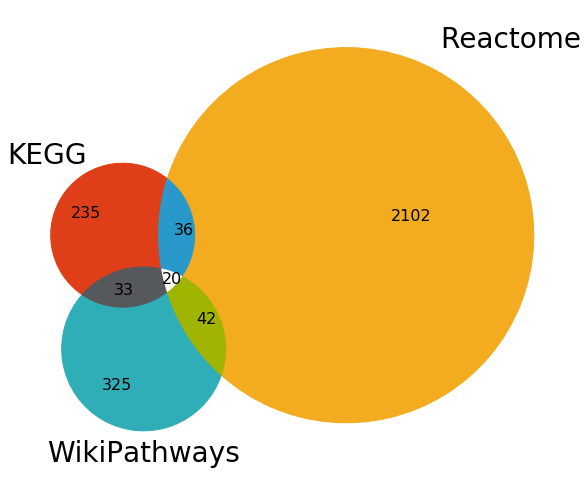

In [10]:
plt.figure(figsize=(10, 10))
diagram = venn3(
    subsets = (235, 2102, 36, 325, 33, 42, 20),
    set_labels = ("KEGG", "Reactome", "WikiPathways")
)
for text in diagram.set_labels:
    text.set_fontsize(28)
for text in diagram.subset_labels:
    text.set_fontsize(16)


diagram.get_patch_by_id('001').set_color('#2faeb7') #WikiPathways
diagram.get_patch_by_id('001').set_alpha(1.0)
diagram.get_patch_by_id('010').set_color('#f3ac1f')
diagram.get_patch_by_id('010').set_alpha(1.0)
diagram.get_patch_by_id('011').set_color('#a1b401')
diagram.get_patch_by_id('011').set_alpha(1.0)
diagram.get_patch_by_id('100').set_color('#df3f18')
diagram.get_patch_by_id('100').set_alpha(1.0)
diagram.get_patch_by_id('110').set_color('#2999cb')
diagram.get_patch_by_id('110').set_alpha(1.0)
diagram.get_patch_by_id('111').set_color('#ffffff')
diagram.get_patch_by_id('111').set_alpha(1.0)
diagram.get_patch_by_id('101').set_color('#55595c')
diagram.get_patch_by_id('101').set_alpha(1.0)
    
plt.show()


Venn diagram representing the equivalent pathways between the three pathway databases

# List of pathways present in all three databases

KEGG | Reactome | WikiPathways
---- |----------|-------------
[Mismatch repair - Homo sapiens (human)](http://www.genome.jp/kegg-bin/show_pathway?hsa03430)  | [Mismatch Repair](https://reactome.org/content/detail/R-HSA-5358508) | [Mismatch repair](https://www.wikipathways.org/index.php/Pathway:WP3381)
[Thyroid hormone synthesis - Homo sapiens (human)](http://www.genome.jp/kegg-bin/show_pathway?map=hsa04918&show_description=show)  | [Thyroxine biosynthesis](http://www.reactome.org/content/detail/R-DDI-209968) | [Thyroxine (Thyroid Hormone) Production](https://www.wikipathways.org/index.php/Pathway:WP1981)
[Wnt signaling pathway - Homo sapiens (human)](http://www.genome.jp/kegg-bin/show_pathway?hsa04310)  | [Signaling by WNT](https://reactome.org/content/detail/R-HSA-195721) | [Wnt Signaling Pathway](https://www.wikipathways.org/index.php/Pathway:WP363)
[MAPK signaling pathway - Homo sapiens (human)](http://www.genome.jp/kegg/pathway/hsa/hsa04010.html)  | [MAPK family signaling cascades](https://reactome.org/content/detail/R-HSA-5683057) | [MAPK Signaling Pathway](https://www.wikipathways.org/index.php/Pathway:WP382)
[Pentose phosphate pathway - Homo sapiens (human)](http://www.genome.jp/kegg-bin/show_pathway?hsa00030)  | [Pentose phosphate pathway (hexose monophosphate shunt)](http://www.reactome.org/content/detail/R-HSA-71336) | [Pentose Phosphate Pathway](https://www.wikipathways.org/index.php/Pathway:WP134)
[PI3K-Akt signaling pathway - Homo sapiens (human)](http://www.genome.jp/kegg-bin/show_pathway?hsa04151)  | [PI3K/AKT activation](https://reactome.org/content/detail/R-RNO-198203) | [PI3K-Akt Signaling Pathway](https://www.wikipathways.org/index.php/Pathway:WP4172)
[Toll-like receptor signaling pathway - Homo sapiens (human)](http://www.genome.jp/kegg-bin/show_pathway?hsa04620)  | [Toll-Like Receptors Cascades](https://reactome.org/content/detail/R-HSA-168898)| [Toll-like Receptor Signaling Pathway](https://www.wikipathways.org/index.php/Pathway:WP75)
[Toll-like receptor signaling pathway - Homo sapiens (human)](link)  | [Toll-Like Receptors Cascades](link)| [Toll-like Receptor Signaling](link)
[Notch signaling pathway - Homo sapiens (human)](http://www.genome.jp/kegg-bin/show_pathway?hsa04330)  | [Signaling by NOTCH](https://reactome.org/content/detail/R-HSA-157118) | [Notch Signaling Pathway](https://www.wikipathways.org/index.php/Pathway:WP268)
[Apoptosis - Homo sapiens (human)](http://www.genome.jp/kegg/pathway/hsa/hsa04210.html)  | [Apoptosis](http://www.reactome.org/content/detail/R-CEL-109581) | [Apoptosis](link)
[Sphingolipid metabolism - Homo sapiens (human)](http://www.genome.jp/kegg-bin/show_pathway?hsa00600)  | [Sphingolipid metabolism](https://reactome.org/content/detail/R-DDI-428157) | [Sphingolipid Metabolism](https://www.wikipathways.org/index.php/Pathway:WP2788)
[Hedgehog signaling pathway - Homo sapiens (human)](http://www.genome.jp/kegg-bin/show_pathway?hsa04340)  | [Signaling by Hedgehog](http://www.reactome.org/content/detail/R-HSA-5358351) | [Hedgehog Signaling Pathway](https://www.wikipathways.org/index.php/Pathway:WP47)
[Citrate cycle (TCA cycle) - Homo sapiens (human)](http://www.genome.jp/kegg-bin/show_pathway?hsa00020)  | [Citric acid cycle (TCA cycle)](http://www.reactome.org/content/detail/R-HSA-71403) | [TCA Cycle](https://www.wikipathways.org/index.php/Pathway:WP78)
[DNA replication - Homo sapiens (human)](http://www.genome.jp/kegg-bin/show_pathway?hsa03030)  | [DNA Replication](https://reactome.org/content/detail/R-HSA-69306) | [DNA Replication](https://www.wikipathways.org/index.php/Pathway:WP466)
[Non-homologous end-joining - Homo sapiens (human)](http://www.kegg.jp/kegg-bin/show_pathway?hsa03450)  | [Nonhomologous End-Joining (NHEJ)](http://www.reactome.org/content/detail/R-HSA-5693571.1) | [Non-homologous end joining](https://www.wikipathways.org/index.php/Pathway:WP438)
[Cell cycle - Homo sapiens (human)](http://www.genome.jp/kegg-bin/show_pathway?hsa04110)  | [Cell Cycle](https://reactome.org/content/detail/R-HSA-1640170) | [Cell Cycle](https://www.wikipathways.org/index.php/Pathway:WP179)
[TGF-beta signaling pathway - Homo sapiens (human)](http://www.genome.jp/kegg-bin/show_pathway?hsa04350)  | [Signaling by TGF-beta family members](http://www.reactome.org/content/detail/R-HSA-9006936) | [TGF-beta Signaling Pathway](https://www.wikipathways.org/index.php/Pathway:WP366)
[mTOR signaling pathway - Homo sapiens (human)](http://www.genome.jp/kegg-bin/show_pathway?hsa04150)  | [mTOR signalling](https://reactome.org/content/detail/R-HSA-165159) | [Target Of Rapamycin (TOR) Signaling](https://www.wikipathways.org/index.php/Pathway:WP1575)
[IL-17 signaling pathway - Homo sapiens (human)](http://www.genome.jp/kegg-bin/show_pathway?map=hsa04657&show_description=show)  | [Interleukin-17 signaling](https://reactome.org/content/detail/R-HSA-448424) | [IL17 signaling pathway](https://www.wikipathways.org/index.php/Pathway:WP2112)
[Synthesis and degradation of ketone bodies - Homo sapiens (human)](http://www.genome.jp/kegg-bin/show_pathway?hsa00072)  | [Ketone body metabolism](http://reactome.org/content/detail/R-HSA-74182) | [Synthesis and Degradation of Ketone Bodies](https://www.wikipathways.org/index.php/Pathway:WP311)